In [43]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


nltk.data.path.append('/Users/naveenverma/nltk_data')


stemmer = PorterStemmer()

# A function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

# A function for tokenizing and further processing each message
def tokenize_message(message):
    # Tokenize the message
    tokens = word_tokenize(message)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Stem the tokens
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [45]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, reg_param=0.1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.reg_param = reg_param
        self.theta = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _loss(self, X, y):
        z = np.dot(X, self.theta)
        h = self._sigmoid(z)
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
        # Regularization term
        reg_term = self.reg_param * np.sum(self.theta[1:] ** 2)
        loss += reg_term
        return loss

    def _gradient(self, X, y):
        z = np.dot(X, self.theta)
        h = self._sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / len(y)
        # Regularization term gradient
        reg_gradient = self.reg_param * np.concatenate(([0], self.theta[1:] * 2))
        gradient += reg_gradient
        return gradient

    def fit(self, X, y):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        self.theta = np.zeros(X.shape[1])
        prev_loss = float('inf')

        for i in range(self.max_iter):
            gradient = self._gradient(X, y)
            self.theta -= self.learning_rate * gradient

            loss = self._loss(X, y)
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

    def predict_proba(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        z = np.dot(X, self.theta)
        proba = self._sigmoid(z)
        return proba

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        predictions = (proba >= threshold).astype(int)
        return predictions


In [46]:
# Read the text file into a DataFrame
df = pd.read_csv('/Users/naveenverma/Desktop/NewStart/Dataset/a1-data/SMSSpamCollection', sep='\t', header=None, names=['Label', 'Message'])
# Data table
print(df.head())

# Apply preprocessing and tokenization to each message
df['Processed_Message'] = df['Message'].apply(preprocess_text)
df['Tokenized_Message'] = df['Processed_Message'].apply(tokenize_message)

# Convert the text tokens back to strings
df['Tokenized_Message'] = df['Tokenized_Message'].apply(lambda x: ' '.join(x))

# Split the dataset into train, test, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Reset index for each dataset
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

# Print the sizes of the resulting sets
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))
print("Validation set size:", len(val_data))

# Prepare data for training
X_train = train_data['Tokenized_Message'].values
y_train = train_data['Label'].map({'ham': 0, 'spam': 1}).values

X_test = test_data['Tokenized_Message'].values
y_test = test_data['Label'].map({'ham': 0, 'spam': 1}).values

X_val = val_data['Tokenized_Message'].values
y_val = val_data['Label'].map({'ham': 0, 'spam': 1}).values

  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Train set size: 3343
Test set size: 1114
Validation set size: 1115


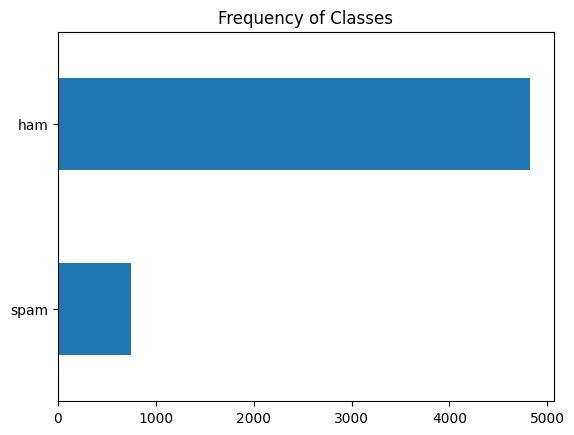

In [47]:
# Class distribution
import matplotlib.pyplot as plt
df['Label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [48]:
# Calculate evaluation metrics
def calculate_metrics(true_labels, predicted_labels):
    # Calculate accuracy
    accuracy = np.mean(true_labels == predicted_labels)

    # Calculate true positives, true negatives, false positives, false negatives
    tp = np.sum((true_labels == 0) & (predicted_labels == 0))
    tn = np.sum((true_labels == 0) & (predicted_labels == 1))
    fp = np.sum((true_labels == 1) & (predicted_labels == 0))
    fn = np.sum((true_labels == 1) & (predicted_labels == 1))

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

In [49]:
model = LogisticRegression()

# For training, we need to convert the text data into numerical features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
model.fit(X_train_tfidf.toarray(), y_train)

# Make predictions on the test set
X_test_tfidf = tfidf_vectorizer.transform(X_test)
predictions = model.predict(X_test_tfidf.toarray())

X_val_tfidf = tfidf_vectorizer.transform(X_val)

predictions = model.predict(X_test_tfidf.toarray())

# Calculate evaluation metrics
accuracy, precision, recall, f1_score = calculate_metrics(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.8599640933572711
Precision: 0.8599640933572711
Recall: 1.0
F1 Score: 0.9247104247104247


In [50]:
class SGDLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, reg_param=0.1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.reg_param = reg_param
        self.theta = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _loss(self, X, y):
        z = np.dot(X, self.theta)
        h = self._sigmoid(z)
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
        # Regularization term
        reg_term = self.reg_param * np.sum(self.theta[1:] ** 2)
        loss += reg_term
        return loss

    def fit(self, X, y):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        self.theta = np.zeros(X.shape[1])
        prev_loss = float('inf')

        for _ in range(self.max_iter):
            # Shuffle the data
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(len(X)):
                xi = X_shuffled[i]
                yi = y_shuffled[i]
                gradient = self._gradient(xi, yi)
                self.theta -= self.learning_rate * gradient

            loss = self._loss(X, y)
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

    def _gradient(self, xi, yi):
        z = np.dot(xi, self.theta)
        h = self._sigmoid(z)
        gradient = np.dot(xi.T, (h - yi))
        # Regularization term gradient
        reg_gradient = self.reg_param * np.concatenate(([0], self.theta[1:] * 2))
        gradient += reg_gradient
        return gradient / len(yi) if hasattr(yi, "__len__") else gradient


    def predict_proba(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]  # add intercept term
        z = np.dot(X, self.theta)
        proba = self._sigmoid(z)
        return proba

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        predictions = (proba >= threshold).astype(int)
        return predictions



In [51]:
sgd_classifier = SGDLogisticRegression(learning_rate=0.01, max_iter=1000, tol=1e-4)

# Fit the model to the training data
sgd_classifier.fit(X_train_tfidf.toarray(), y_train)

# Make predictions on the test data
predictions = sgd_classifier.predict(X_test_tfidf.toarray())

# Calculate evaluation metrics
accuracy, precision, recall, f1_score = calculate_metrics(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.8599640933572711
Precision: 0.8599640933572711
Recall: 1.0
F1 Score: 0.9247104247104247


In [39]:
class MiniBatchLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, batch_size=32, random_state=None, reg_param=0.1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
        self.random_state = random_state
        self.reg_param = reg_param
        self.theta = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _initialize_weights(self, n_features):
        np.random.seed(self.random_state)
        self.theta = np.random.randn(n_features)

    def _compute_gradient(self, X, y):
        z = np.dot(X, self.theta)
        h = self._sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / len(y)
        # Regularization term gradient
        reg_gradient = self.reg_param * np.concatenate(([0], self.theta[1:] * 2))
        gradient += reg_gradient
        return gradient

    def _compute_loss(self, X, y):
        z = np.dot(X, self.theta)
        h = self._sigmoid(z)
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
        # Regularization term
        reg_term = self.reg_param * np.sum(self.theta[1:] ** 2)
        loss += reg_term
        return loss

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._initialize_weights(n_features)
        prev_loss = float('inf')

        for _ in range(self.max_iter):
            X_shuffled, y_shuffled = self._shuffle_data(X, y)
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                gradient = self._compute_gradient(X_batch, y_batch)
                self.theta -= self.learning_rate * gradient

            loss = self._compute_loss(X_shuffled, y_shuffled)
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

    def predict_proba(self, X):
        z = np.dot(X, self.theta)
        proba = self._sigmoid(z)
        return proba

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        predictions = (proba >= threshold).astype(int)
        return predictions

    def _shuffle_data(self, X, y):
        indices = np.random.permutation(X.shape[0])
        return X[indices], y[indices]

In [52]:
mini_batch_classifier = MiniBatchLogisticRegression(learning_rate=0.01, max_iter=1000, tol=1e-4, random_state=42)

# Fit the model to the training data
mini_batch_classifier.fit(X_train_tfidf.toarray(), y_train)

# Make predictions on the test data
predictions = mini_batch_classifier.predict(X_test_tfidf.toarray())

# Calculate evaluation metrics
accuracy, precision, recall, f1_score = calculate_metrics(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9210053859964094
Precision: 0.9239766081871345
Recall: 0.9239766081871345
F1 Score: 0.9239766081871345


In [53]:
# Make predictions on the validation set
X_val_tfidf = tfidf_vectorizer.transform(val_data['Tokenized_Message'].values)


# Define a list of regularization parameter values to try
lambda_values = [0.001, 0.01, 0.1, 1, 10]

best_lambda = None
best_f1_score = -1  # Initialize with a value that will definitely be lower than any actual F1 score

# Loop over lambda values
for reg_param in lambda_values:
    # Train the model
    model = LogisticRegression(reg_param=reg_param)
    model.fit(X_train_tfidf.toarray(), y_train)

    # Make predictions on the validation set
    predictions = model.predict(X_val_tfidf.toarray())

    # Calculate F1 score
    _, _, _, f1_score = calculate_metrics(y_val, predictions)

    # Check if this lambda value gives better F1 score
    if f1_score > best_f1_score:
        best_lambda = reg_param
        best_f1_score = f1_score

# Train the model with the best lambda on the entire training set
best_model = LogisticRegression(reg_param=best_lambda)
best_model.fit(X_train_tfidf.toarray(), y_train)
predictions = best_model.predict(X_val_tfidf.toarray())
# Evaluate on the validation set
accuracy, precision, recall, f1_score = calculate_metrics(y_val, predictions)

print("Best lambda:", best_lambda)
print("Test Set Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Best lambda: 0.001
Test Set Metrics:
Accuracy: 0.8699551569506726
Precision: 0.8699551569506726
Recall: 1.0
F1 Score: 0.9304556354916067


As compare to my Logistic Regression and Stochastic GD, mini batch logistic regression performed well because mini batch gradient descent combines the advantage of both GD and SGD.
1 - It is efficient.
2 - It tries to avoid local minima by updating the parameters on a small subset of data.